# Motif Analysis

In [1]:
library(Signac)
library(Seurat)
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Mmusculus.UCSC.mm10)
library(patchwork)
set.seed(1234)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching SeuratObject


Attaching package: 'Seurat'


The following object is masked from 'package:Signac':

    FoldChange




Loading required package: BSgenome

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Pos

## 0. Load the data

In [2]:
brain <- readRDS("./adult_mouse_brain/Outputs/brain_coaccs.rds")

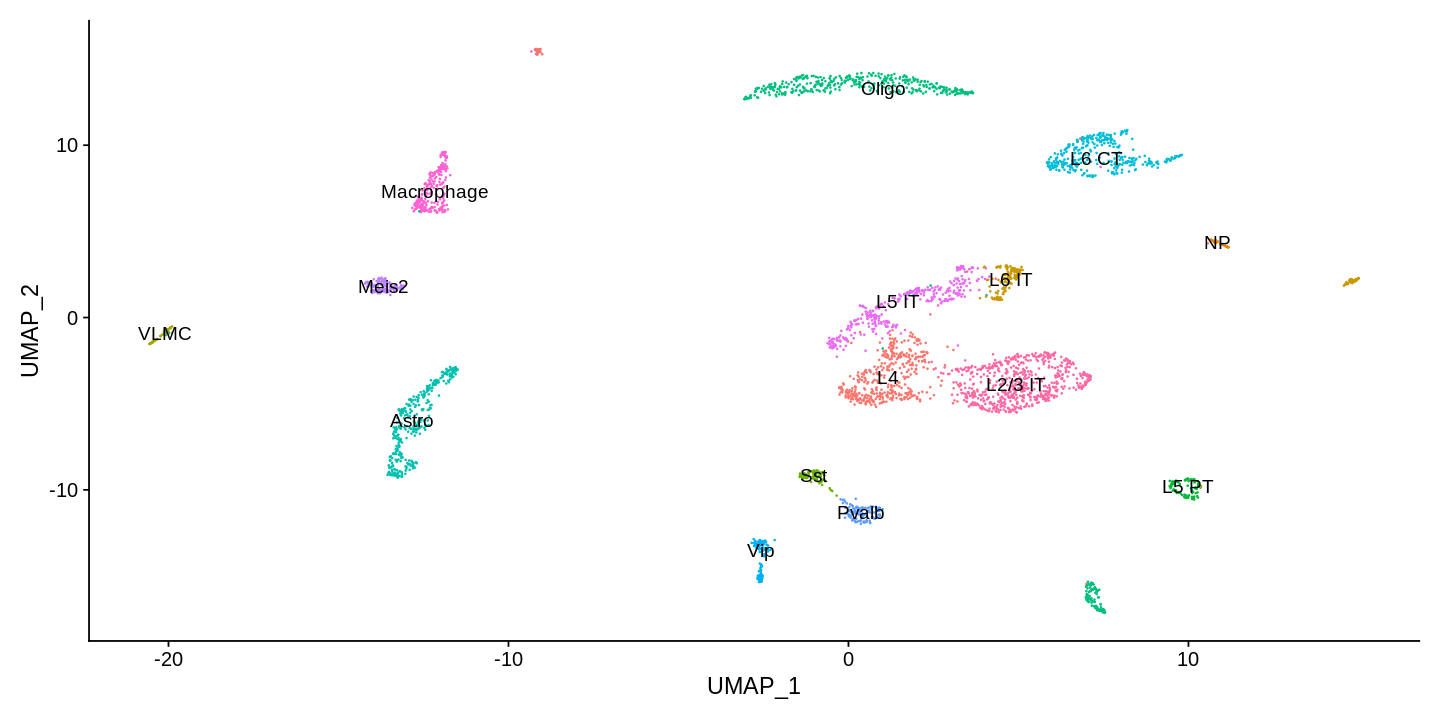

In [13]:
p1 <- DimPlot(brain, label = TRUE, pt.size = 0.1) + NoLegend()
p1

## Add motif information

In [3]:
DefaultAssay(brain) <- 'ATAC'

#Get the list of motif position frequency matrices from JASPAR Database. 
#(we can also use chromVARmotifs instead of JASPAR)

#10090 Mus musculus
#7742 Vertebrata

pfm <- getMatrixSet(x = JASPAR2020,
                    opts = list(species = 10090, all_versions = FALSE)) #check taxonomy ID for the respective species

# add motif information
brain <- AddMotifs(object = brain,
                   genome = BSgenome.Mmusculus.UCSC.mm10,
                   pfm = pfm)

Building motif matrix

Finding motif positions

Creating Motif object



## Find overrepresented motifs

To identify potentially important cell-type-specific regulatory sequences, we can search for DNA motifs that are overrepresented in a set of peaks that are differentially accessible between cell types.

Here, we find differentially accessible peaks between Pvalb and Sst inhibitory interneurons. We then perform a hypergeometric test to test the probability of observing the motif at the given frequency by chance, comparing with a background set of peaks matched for GC content.

In [4]:
da_peaks <- FindMarkers(
  object = brain,
  ident.1 = 'Pvalb',
  ident.2 = 'Sst',
  only.pos = TRUE,
  test.use = 'LR',
  latent.vars = 'nCount_ATAC'
)

# get top differentially accessible peaks
top.da.peak <- rownames(da_peaks[da_peaks$p_val < 0.005, ])

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Matching the set of background peaks is essential when finding enriched DNA sequence motifs. By default, we choose a set of peaks matched for GC content, but it can be sometimes be beneficial to further restrict the background peaks to those that are accessible in the groups of cells compared when finding differentially accessible peaks.

The AccessiblePeaks() function can be used to find a set of peaks that are open in a subset of cells. We can use this function to first restrict the set of possible background peaks to those peaks that were open in the set of cells compared in FindMarkers(), and then create a GC-content-matched set of peaks from this larger set using MatchRegionStats().

In [5]:
# find peaks open in Pvalb or Sst cells
open.peaks <- AccessiblePeaks(brain, idents = c("Pvalb", "Sst"))

# match the overall GC content in the peak set
meta.feature <- GetAssayData(brain, assay = "ATAC", slot = "meta.features")
peaks.matched <- MatchRegionStats(
  meta.feature = meta.feature[open.peaks, ],
  query.feature = meta.feature[top.da.peak, ],
  n = 50000
)

Matching GC.percent distribution



peaks.matched can then be used as the background peak set by setting background=peaks.matched in FindMotifs().

In [6]:
# test enrichment
enriched.motifs <- FindMotifs(
  object = brain,
  features = top.da.peak
)

Selecting background regions to match input sequence characteristics

Matching GC.percent distribution

Testing motif enrichment in 2436 regions



We can also plot the position weight matrices for the motifs, so we can visualize the different motif sequences.

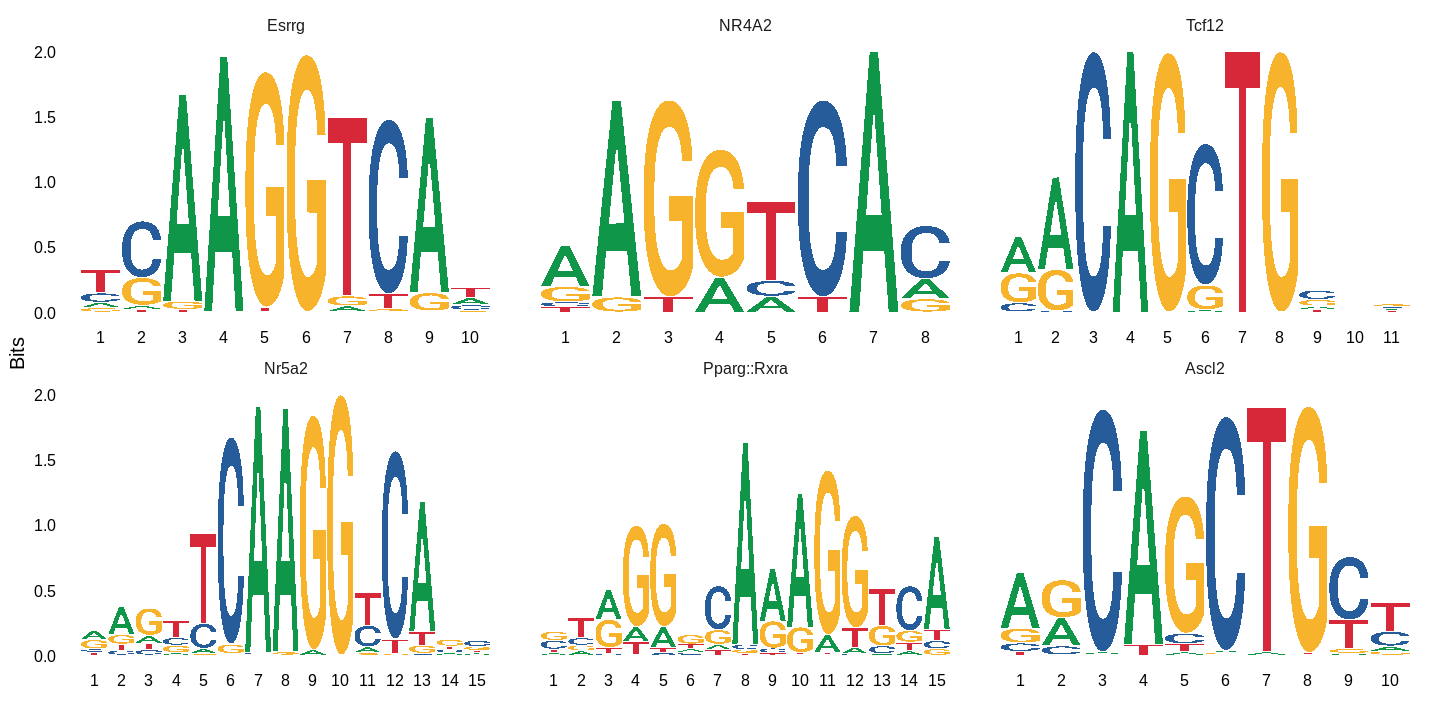

In [7]:
options(repr.plot.width=12, repr.plot.height=6)

MotifPlot(
  object = brain,
  motifs = head(rownames(enriched.motifs)))

We and others have previously shown that Mef-family motifs, particularly Mef2c, are enriched in Pvalb-specific peaks in scATAC-seq data (https://doi.org/10.1016/j.cell.2019.05.031; https://doi.org/10.1101/615179), and further shown that Mef2c is required for the development of Pvalb interneurons (https://www.nature.com/articles/nature25999). Here our results are consistent with these findings, and we observe a strong enrichment of Mef-family motifs in the top results from FindMotifs().

## Computing motif activities

We can also compute a per-cell motif activity score by running chromVAR. This allows us to visualize motif activities per cell, and also provides an alternative method of identifying differentially-active motifs between cell types.

ChromVAR identifies motifs associated with variability in chromatin accessibility between cells. See the chromVAR paper for a complete description of the method.

In [8]:
brain <- RunChromVAR(
  object = brain,
  genome = BSgenome.Mmusculus.UCSC.mm10
)

Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay



In [9]:
brain

An object of class Seurat 
184288 features across 3512 samples within 4 assays 
Active assay: ATAC (157203 features, 157203 variable features)
 3 other assays present: ACTIVITY, RNA, chromvar
 2 dimensional reductions calculated: lsi, umap

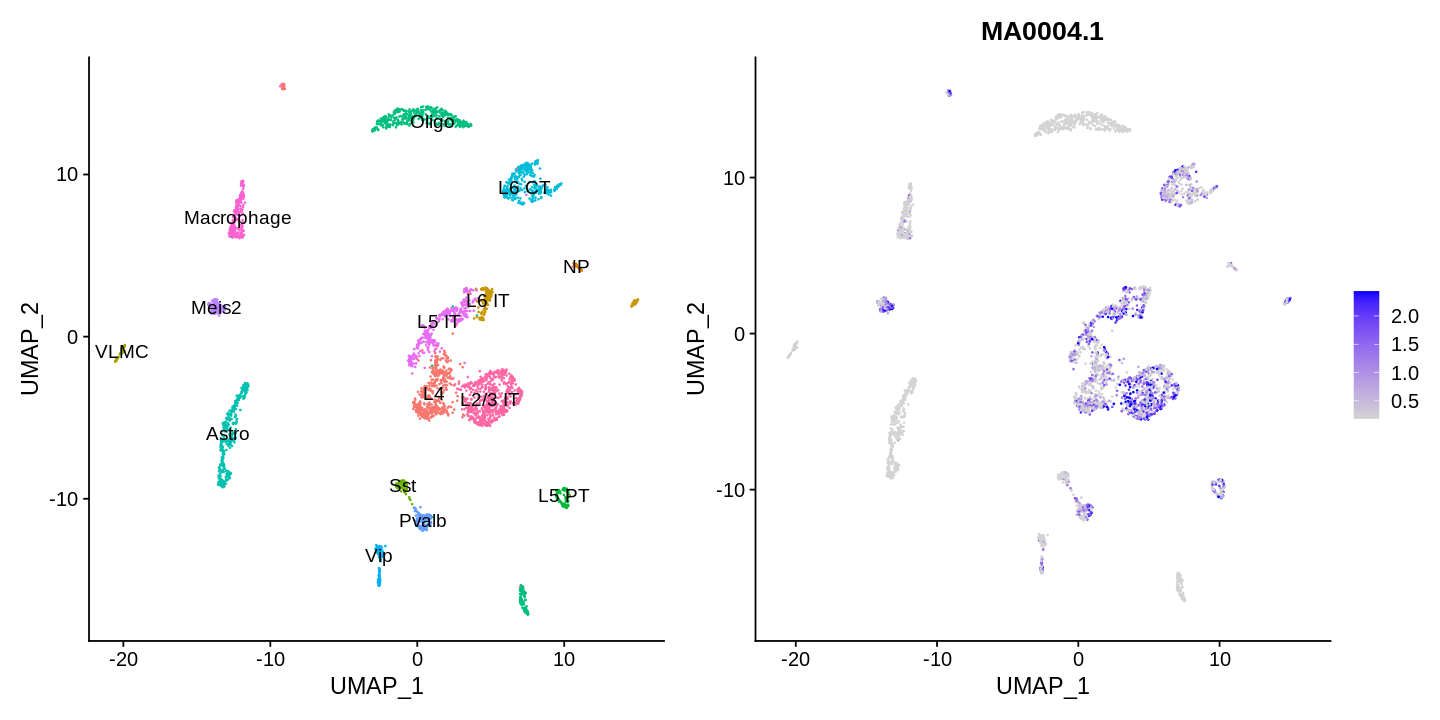

In [14]:
DefaultAssay(brain) <- 'chromvar'

# look at the activity of Arnt (see JASPAR for correspondence)
p2 <- FeaturePlot(
  object = brain,
  features = "MA0004.1",
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)
p1 + p2

We can also directly test for differential activity scores between cell types. This tends to give similar results as performing an enrichment test on differentially accessible peaks between the cell types (shown above).

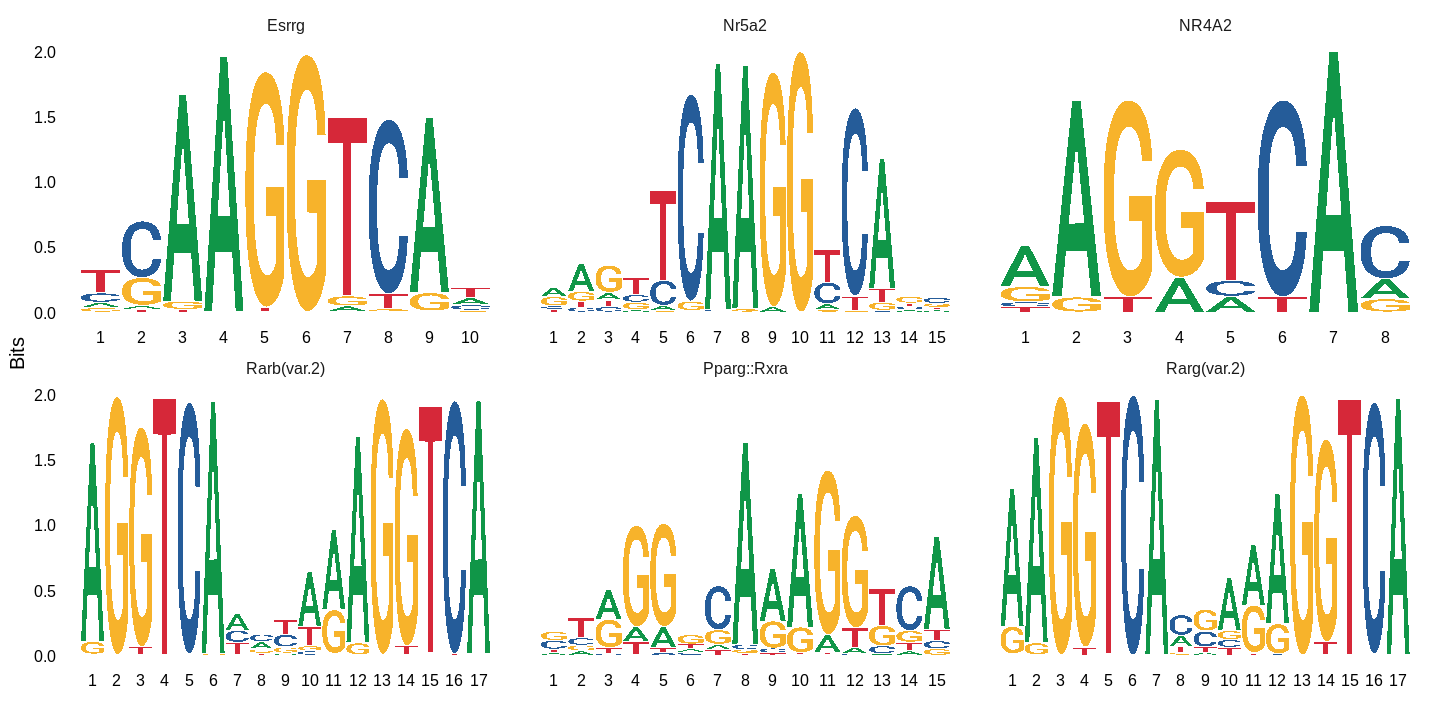

In [15]:
differential.activity <- FindMarkers(
  object = brain,
  ident.1 = 'Pvalb',
  ident.2 = 'Sst',
  only.pos = TRUE,
  test.use = 'LR',
  latent.vars = 'nCount_ATAC'
)

MotifPlot(
  object = brain,
  motifs = head(rownames(differential.activity)),
  assay = 'ATAC'
)


In [16]:
saveRDS(brain, file = "./adult_mouse_brain/Outputs/brain_motif.rds")